# Imports

Requirements:
- python 3.6
- numpy
- matplotlib
- seaborn
- pytorch
- torchvision
- tqdm
- joblib

Note: some of the images won't show on github, but they should if you download the notebook locally and use a recent enough version of jupyter.

In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
import multiprocessing
import os.path
import csv
import copy
import joblib
from torchvision import datasets
import torchvision
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("white")
from pdb import set_trace as bp

In [15]:
USE_CUDA = torch.cuda.is_available()

def w(v):
    if USE_CUDA:
        return v.cuda()
    return v


In [16]:
!mkdir -p _cache
cache = joblib.Memory(location='_cache', verbose=0)

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file _cache already exists.
Error occurred while processing: _cache.


In [17]:
from meta_module import *

# Intro

This notebook is a reproduction of the paper "Learning to Learn by Gradient Descent by Gradient Descent" (https://arxiv.org/abs/1606.04474). 

In a word, this paper is trying to replace the optimizers normally used for neural networks (eg Adam, RMSprop, SGD etc.) by a recurrent neural network: after all, gradient descent is fundamentally a **sequence** of updates (from the output layer of the neural net back to the input), in between which a **state** must be stored. Thus we can think of an optimizer as a mini-RNN. The idea in this paper is to actually train that RNN instead of using a generic algorithm like Adam/SGD/etc..

## Loss

The loss function described in the paper seems complicated, but in reality it is very simple: all it is saying is that the loss of the optimizer is the sum of the losses of the optimizee as it learns. The paper includes some notion of weighing but gives a weight of 1 to everything, so that it indeed is just the sum.

$$\mathcal{L}(\phi) = \mathbb{E}_f \left[ \sum_{t=1}^T w_t f(\theta_t) \right]$$
where
$$\theta_{t+1} = \theta_t + g_t$$
$$\begin{bmatrix} g_t \\ h_{t+1} \end{bmatrix} = m(\nabla_t, h_t, \phi)$$

The $w_t$ are arbitrary weights for each timestep. If we only set the last $w_t$ to 1 and the rest to 0, we are optimizing for the best **final** result with our optimizee. This seems reasonable, but it makes it much harder to train. Instead we will use $w_t$ = 1 for all $t$. $\nabla_t = \nabla_{\theta} f(\theta_t)$.

$f$ is the *optimizee* function, and $\theta_t$ is its parameters at time $t$.
$m$ is the *optimizer* function, $\phi$ is its parameters. $h_t$ is its state at time $t$. $g_t$ is the update it outputs at time $t$.

The plan is thus to use gradient descent on $\phi$ in order to minimize $\mathcal{L}(\phi)$, which should give us an optimizer that is capable of optimizing $f$ efficiently.

As the paper mention, it is important that the gradients in dashed lines in the figure below are **not** propagated during gradient descent.

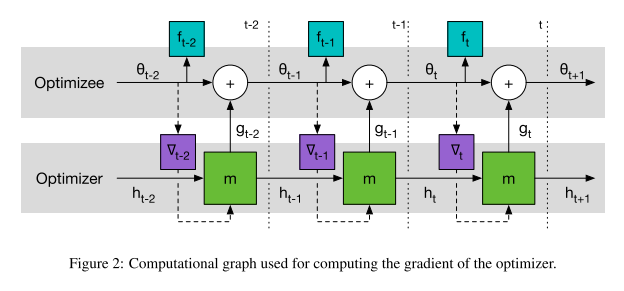

Basically this is nothing we wouldn't expect: the loss of the optimizer neural net is simply the average training loss of the optimizee as it is trained by the optimizer. The optimizer takes in the gradient of the current coordinate of the optimizee as well as its previous state, and outputs a suggested update that we hope will reduce the optimizee's loss as fast as possible.

## Coordinatewise

Informally speaking, coordinatewise optimization is to optimize each parameter by its own state. Any momentum or energy term used in the optimization is based on each parameter's own history, independent on others. Each parameter's optimization state is not shared across other coordinates.

The precondition assumed in ths paper, is that all parameters share the same weights in the LSTM meta optimizer.

# Implementation

As we perform operations, Pytorch builds the computational graph of the operations we perform. However, there are some variables that we want to detach from the graph at various points, specifically we want to pretend that the gradients are inputs (as specified in the previous image) that come from nowhere, instead of coming from the rest of the computational graph as they really do: this means we want to **detach** the gradients from the graph. Likewise, when every 20 steps we perform backpropagation on the optimizer network, we want the current hidden states and cell states, as well as the parameters of the optimizee to "forget" that they are dependent on previous steps in the graph. For all of this, I created a function called `detach_var` which creates a new Variable from the current variable's data, and makes sure that its gradients are still kept. This is different from the `.detach()` function in Pytorch which does not quite forget the original graph and also does not guarantee that the gradients will be there.

In [18]:
def detach_var(v):
    var = w(Variable(v.data, requires_grad=True))
    var.retain_grad()
    return var

import functools

def rsetattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    return setattr(rgetattr(obj, pre) if pre else obj, post, val)

# using wonder's beautiful simplification: https://stackoverflow.com/questions/31174295/getattr-and-setattr-on-nested-objects/31174427?noredirect=1#comment86638618_31174427

def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))

def do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True):
    if should_train:
        opt_net.train()
    else:
        opt_net.eval()
        unroll = 1
    
    target = target_cls(training=should_train)
    optimizee = w(target_to_opt())
    n_params = 0
    for name, p in optimizee.all_named_parameters():
        n_params += int(np.prod(p.size()))
    hidden_states = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
    cell_states = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
    all_losses_ever = []
    if should_train:
        meta_opt.zero_grad()
    all_losses = None
    for iteration in range(1, optim_it + 1):
        loss = optimizee(target)
                    
        if all_losses is None:
            all_losses = loss
        else:
            all_losses += loss
        
        all_losses_ever.append(loss.data.cpu().numpy())
        loss.backward(retain_graph=should_train)

        offset = 0
        result_params = {}
        hidden_states2 = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
        cell_states2 = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
        for name, p in optimizee.all_named_parameters():
            cur_sz = int(np.prod(p.size()))
            # We do this so the gradients are disconnected from the graph but we still get
            # gradients from the rest
            gradients = detach_var(p.grad.view(cur_sz, 1))
            updates, new_hidden, new_cell = opt_net(
                gradients,
                [h[offset:offset+cur_sz] for h in hidden_states],
                [c[offset:offset+cur_sz] for c in cell_states]
            )
            for i in range(len(new_hidden)):
                hidden_states2[i][offset:offset+cur_sz] = new_hidden[i]
                cell_states2[i][offset:offset+cur_sz] = new_cell[i]
            result_params[name] = p + updates.view(*p.size()) * out_mul
            result_params[name].retain_grad()
            
            offset += cur_sz
            
        if iteration % unroll == 0:
            if should_train:
                meta_opt.zero_grad()
                all_losses.backward()
                meta_opt.step()
                
            all_losses = None

            optimizee = w(target_to_opt())
            optimizee.load_state_dict(result_params)
            optimizee.zero_grad()
            hidden_states = [detach_var(v) for v in hidden_states2]
            cell_states = [detach_var(v) for v in cell_states2]
            
        else:
            for name, p in optimizee.all_named_parameters():
                rsetattr(optimizee, name, result_params[name])
            assert len(list(optimizee.all_named_parameters()))
            hidden_states = hidden_states2
            cell_states = cell_states2
            
    return all_losses_ever


@cache.cache
def fit_optimizer(target_cls, target_to_opt, preproc=False, unroll=20, optim_it=100, n_epochs=20, n_tests=100, lr=0.001, out_mul=1.0):
    opt_net = w(Optimizer(preproc=preproc))
    meta_opt = optim.Adam(opt_net.parameters(), lr=lr)
    
    best_net = None
    best_loss = 100000000000000000
    
    for _ in tqdm(range(n_epochs), 'epochs'):
        for _ in tqdm(range(20), 'iterations'):
            do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True)
        
        loss = (np.mean([
            np.sum(do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=False))
            for _ in tqdm(range(n_tests), 'tests')
        ]))
        print(loss)
        if loss < best_loss:
            print(best_loss, loss)
            best_loss = loss
            best_net = copy.deepcopy(opt_net.state_dict())
            
    return best_loss, best_net
  


# Experiment repro

## Quadratic functions

These are pretty simple: our optimizer is supposed to find a 10-element vector called $\theta$ that, when multiplied by a 10x10 matrix called $W$, is as close as possible to a 10-element vector called $y$. Both $y$ and $W$ are generated randomly. The error is simply the squared error.

In [72]:
class QuadraticLoss:
    def __init__(self, **kwargs):
        self.W = w(Variable(torch.randn(10, 10)))
        self.y = w(Variable(torch.randn(10)))
        
    def get_loss(self, theta):
        return torch.sum((self.W.matmul(theta) - self.y)**2)
    
class QuadOptimizee(MetaModule):
    def __init__(self, theta=None):
        super().__init__()
        self.register_buffer('theta', to_var(torch.zeros(10).cuda(), requires_grad=True))
        
    def forward(self, target):
        return target.get_loss(self.theta)
    
    def parameters(self):
        return [self.theta]
    
    def all_named_parameters(self):
        return [('theta', self.theta)]
        
class Optimizer(nn.Module):
    def __init__(self, preproc=False, hidden_sz=20, preproc_factor=10.0):
        super().__init__()
        self.hidden_sz = hidden_sz
        if preproc:
            self.recurs = nn.LSTMCell(2, hidden_sz)
        else:
            self.recurs = nn.LSTMCell(1, hidden_sz)
        self.recurs2 = nn.LSTMCell(hidden_sz, hidden_sz)
        self.output = nn.Linear(hidden_sz, 1)
        self.preproc = preproc
        self.preproc_factor = preproc_factor
        self.preproc_threshold = np.exp(-preproc_factor)
        
    def forward(self, inp, hidden, cell):
        if self.preproc:
            # Implement preproc described in Appendix A
            
            # Note: we do all this work on tensors, which means
            # the gradients won't propagate through inp. This
            # should be ok because the algorithm involves
            # making sure that inp is already detached.
            inp = inp.data
            inp2 = w(torch.zeros(inp.size()[0], 2))
            keep_grads = (torch.abs(inp) >= self.preproc_threshold).squeeze()
            inp2[:, 0][keep_grads] = (torch.log(torch.abs(inp[keep_grads]) + 1e-8) / self.preproc_factor).squeeze()
            inp2[:, 1][keep_grads] = torch.sign(inp[keep_grads]).squeeze()
            
            inp2[:, 0][~keep_grads] = -1
            inp2[:, 1][~keep_grads] = (float(np.exp(self.preproc_factor)) * inp[~keep_grads]).squeeze()
            inp = w(Variable(inp2))
        hidden0, cell0 = self.recurs(inp, (hidden[0], cell[0]))
        hidden1, cell1 = self.recurs2(hidden0, (hidden[1], cell[1]))
        return self.output(hidden1), (hidden0, hidden1), (cell0, cell1)
    

> Each function was optimized for 100 steps and the trained optimizers were unrolled for 20 steps.

I assume this means that each epoch is made up of trying to optimize a
new random function for 100 steps, but we are doing an update of the
optimizer every 20 steps. The number of epochs is thus unspecified, but
according to the graphs it seems to be 100 too.

The experiment below on the various learning rates show that 0.003 is a promising learning rate (it is not the lowest, but we are training on only 20 epochs by default and will then retrain with 100 epochs, so it is good to have a slightly lower learning rate for training for longer). We train our final model using 0.003.

In [56]:
for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'all'):
    print('Trying lr:', lr)
    print(fit_optimizer(QuadraticLoss, QuadOptimizee, lr=lr)[0])

Trying lr: 1.0
72654.98
Trying lr: 0.3
206.54507
Trying lr: 0.1
67.72897
Trying lr: 0.03
68.06192
Trying lr: 0.01
60.177055
Trying lr: 0.003
82.771515
Trying lr: 0.001
81.36987
Trying lr: 0.0003
180.2313
Trying lr: 0.0001
183.00937
Trying lr: 3e-05
2558.2979
Trying lr: 1e-05
177524.02



In [57]:
loss, quad_optimizer = fit_optimizer(QuadraticLoss, QuadOptimizee, lr=0.003, n_epochs=100)
print(loss)

49.164204


Now we need to find the best learning rate for the various comparison optimizers. We end up finding 0.1 for Adam, 0.03 for RMSprop, 0.01 for SGD and 0.01 for SGD with nesterov momentum (aka NAG).

In [74]:
@cache.cache
def fit_normal(target_cls, target_to_opt, opt_class, n_tests=100, n_epochs=100, **kwargs):
    results = []
    for i in tqdm(range(n_tests), 'tests'):
        target = target_cls(training=False)
        optimizee = w(target_to_opt())
        optimizer = opt_class(optimizee.parameters(), **kwargs)
        total_loss = []
        for _ in range(n_epochs):
            loss = optimizee(target)
            
            total_loss.append(loss.data.cpu().numpy())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        results.append(total_loss)
    return results

def find_best_lr_normal(target_cls, target_to_opt, opt_class, **extra_kwargs):
    best_loss = 1000000000000000.0
    best_lr = 0.0
    for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'Learning rates'):
        try:
            loss = best_loss + 1.0
            loss = np.mean([np.sum(s) for s in fit_normal(target_cls, target_to_opt, opt_class, lr=lr, **extra_kwargs)])
        except RuntimeError:
            pass
        if loss < best_loss:
            best_loss = loss
            best_lr = lr
    return best_loss, best_lr

In [75]:
NORMAL_OPTS = [(optim.Adam, {}), (optim.RMSprop, {}), (optim.SGD, {'momentum': 0.9}), (optim.SGD, {'nesterov': True, 'momentum': 0.9})]
OPT_NAMES = ['ADAM', 'RMSprop', 'SGD', 'NAG']

In [76]:
# NB: the momentum parameter for nesterov was found from the following file: https://github.com/torch/optim/blob/master/nag.lua
# since it is mentioned in the paper that "When an optimizer has more parameters than just a learning rate (e.g. decay coefficients for ADAM) we use the default values from the optim package in Torch7."
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(QuadraticLoss, QuadOptimizee, opt, **kwargs))


(103.475525, 0.3)



(118.30155, 0.03)


F:\Programs\anaconda3\envs\learning-to-learn-by-gradient-descent-by-gradient-descent\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less



(111.29969, 0.03)



(92.17494, 0.01)


In [77]:
QUAD_LRS = [0.1, 0.03, 0.01, 0.01]
fit_data = np.zeros((100, 100, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(QuadraticLoss, QuadOptimizee, opt, lr=lr, **extra_kwargs))

opt = w(Optimizer())
opt.load_state_dict(quad_optimizer)
np.random.seed(0)
fit_data[:, :, len(OPT_NAMES)] = np.array([do_fit(opt, None, QuadraticLoss, QuadOptimizee, 1, 100, 100, out_mul=1.0, should_train=False) for _ in range(100)])

Finally we plot the learning curve for LSTM vs the different alternatives. For reference, the plot in the paper looks like this:

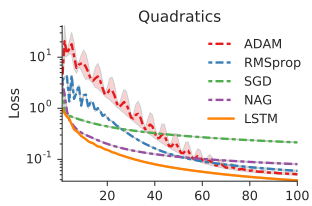

Our result is pretty similar.

F:\Programs\anaconda3\envs\learning-to-learn-by-gradient-descent-by-gradient-descent\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
F:\Programs\anaconda3\envs\learning-to-learn-by-gradient-descent-by-gradient-descent\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


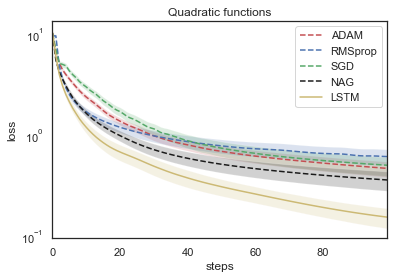

In [78]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Quadratic functions')
plt.show()

## MNIST

Now we move on to MNIST. Because all the rest of our code is implemented, we just need to implement the network specified in the paper, namely a single hidden layer, sigmoid, 20 hidden units network. We make it easy to change sigmoid to some other activation, add layers, and change the number of units, because all of these are attempted in the paper.

In [81]:
class MNISTLoss:
    def __init__(self, training=True):
        dataset = datasets.MNIST(
            '/home/chenwy/mnist', train=True, download=True,
            transform=torchvision.transforms.ToTensor()
        )
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2]
        else:
            indices = indices[len(indices) // 2:]

        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices))

        self.batches = []
        self.cur_batch = 0
        
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

class MNISTNet(MetaModule):
    def __init__(self, layer_size=20, n_layers=1, **kwargs):
        super().__init__()

        inp_size = 28*28
        self.layers = {}
        for i in range(n_layers):
            self.layers[f'mat_{i}'] = MetaLinear(inp_size, layer_size)
            inp_size = layer_size

        self.layers['final_mat'] = MetaLinear(inp_size, 10)
        self.layers = nn.ModuleDict(self.layers)

        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()

    def all_named_parameters(self):
        return [(k, v) for k, v in self.named_parameters()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(inp.size()[0], 28*28)))
        out = w(Variable(out))

        cur_layer = 0
        while f'mat_{cur_layer}' in self.layers:
            inp = self.activation(self.layers[f'mat_{cur_layer}'](inp))
            cur_layer += 1

        inp = F.log_softmax(self.layers['final_mat'](inp), dim=1)
        l = self.loss(inp, out)
        return l

Like before, we find a promising learning rate (0.001) using a small number of epochs (10) and optimize it fully using more epochs (50).

In [ ]:
for lr in tqdm(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], key=lambda x: np.abs(x - 0.003)), 'all'):
    print('Trying lr:', lr)
    print(fit_optimizer(MNISTLoss, MNISTNet, lr=lr, out_mul=0.1, preproc=True, n_tests=5, n_epochs=10)[0])

Trying lr: 0.003


















0it [00:00, ?it/s]















  0%|          | 0/9912422 [00:00<?, ?it/s]















  0%|          | 16384/9912422 [00:00<02:32, 64702.91it/s]















  0%|          | 24576/9912422 [00:00<03:19, 49604.45it/s]















  0%|          | 32768/9912422 [00:01<03:54, 42217.56it/s]















  0%|          | 40960/9912422 [00:01<04:12, 39051.84it/s]















  0%|          | 49152/9912422 [00:01<04:28, 36775.19it/s]















  1%|          | 57344/9912422 [00:01<04:39, 35250.96it/s]















  1%|          | 65536/9912422 [00:02<04:48, 34189.69it/s]















  1%|          | 73728/9912422 [00:02<05:03, 32387.84it/s]















  1%|          | 81920/9912422 [00:02<04:55, 33216.33it/s]















  1%|          | 90112/9912422 [00:02<04:59, 32803.17it/s]















  1%|          | 98304/9912422 [00:03<05:01, 32520.41it/s]















  1%|          | 106496/9912422 [00:03<05:02, 32384.29it/s]















  

  9%|▉         | 901120/9912422 [00:28<04:42, 31904.32it/s]















  9%|▉         | 909312/9912422 [00:28<04:41, 31930.55it/s]















  9%|▉         | 917504/9912422 [00:28<04:44, 31647.28it/s]















  9%|▉         | 925696/9912422 [00:28<04:40, 32021.92it/s]















  9%|▉         | 933888/9912422 [00:29<04:41, 31884.86it/s]















 10%|▉         | 942080/9912422 [00:29<04:45, 31421.28it/s]















 10%|▉         | 950272/9912422 [00:29<04:38, 32156.19it/s]















 10%|▉         | 958464/9912422 [00:29<04:38, 32107.27it/s]















 10%|▉         | 966656/9912422 [00:30<04:39, 31977.99it/s]















 10%|▉         | 974848/9912422 [00:30<04:37, 32153.80it/s]















 10%|▉         | 983040/9912422 [00:30<04:44, 31387.03it/s]















 10%|▉         | 991232/9912422 [00:30<04:37, 32138.72it/s]















 10%|█         | 999424/9912422 [00:31<04:54, 30261.00it/s]















 10%|█         | 1007616/

 18%|█▊        | 1794048/9912422 [00:56<04:13, 31991.91it/s]















 18%|█▊        | 1802240/9912422 [00:56<04:25, 30523.24it/s]















 18%|█▊        | 1810432/9912422 [00:56<04:09, 32434.31it/s]















 18%|█▊        | 1818624/9912422 [00:56<04:12, 32104.29it/s]















 18%|█▊        | 1826816/9912422 [00:57<04:10, 32281.38it/s]















 19%|█▊        | 1835008/9912422 [00:57<04:11, 32112.43it/s]















 19%|█▊        | 1843200/9912422 [00:57<04:11, 32027.32it/s]















 19%|█▊        | 1851392/9912422 [00:57<04:11, 32043.07it/s]















 19%|█▉        | 1859584/9912422 [00:58<04:12, 31904.68it/s]















 19%|█▉        | 1867776/9912422 [00:58<04:11, 31938.96it/s]















 19%|█▉        | 1875968/9912422 [00:58<04:11, 31896.78it/s]















 19%|█▉        | 1884160/9912422 [00:59<04:30, 29636.84it/s]















 19%|█▉        | 1892352/9912422 [00:59<04:07, 32404.39it/s]















 19%|█▉     

 27%|██▋       | 2678784/9912422 [01:23<03:38, 33109.02it/s]















 27%|██▋       | 2686976/9912422 [01:23<03:35, 33561.90it/s]















 27%|██▋       | 2695168/9912422 [01:24<03:38, 33024.44it/s]















 27%|██▋       | 2703360/9912422 [01:24<03:41, 32567.14it/s]















 27%|██▋       | 2711552/9912422 [01:24<03:41, 32554.68it/s]















 27%|██▋       | 2719744/9912422 [01:24<03:43, 32148.97it/s]















 28%|██▊       | 2727936/9912422 [01:25<03:41, 32379.30it/s]















 28%|██▊       | 2736128/9912422 [01:25<03:42, 32181.08it/s]















 28%|██▊       | 2744320/9912422 [01:25<03:42, 32222.66it/s]















 28%|██▊       | 2752512/9912422 [01:25<03:42, 32202.91it/s]















 28%|██▊       | 2760704/9912422 [01:26<04:00, 29753.07it/s]















 28%|██▊       | 2768896/9912422 [01:26<03:38, 32753.24it/s]















 28%|██▊       | 2777088/9912422 [01:26<03:42, 32123.95it/s]















 28%|██▊    

 36%|███▌      | 3563520/9912422 [01:51<03:17, 32086.37it/s]















 36%|███▌      | 3571712/9912422 [01:51<03:19, 31840.75it/s]















 36%|███▌      | 3579904/9912422 [01:51<03:18, 31966.89it/s]















 36%|███▌      | 3588096/9912422 [01:52<03:18, 31902.66it/s]















 36%|███▋      | 3596288/9912422 [01:52<03:16, 32079.52it/s]















 36%|███▋      | 3604480/9912422 [01:52<03:17, 31996.10it/s]















 36%|███▋      | 3612672/9912422 [01:52<03:17, 31905.65it/s]















 37%|███▋      | 3620864/9912422 [01:53<03:12, 32645.09it/s]















 37%|███▋      | 3629056/9912422 [01:53<03:10, 32914.46it/s]















 37%|███▋      | 3637248/9912422 [01:53<03:08, 33344.67it/s]















 37%|███▋      | 3645440/9912422 [01:53<03:23, 30771.31it/s]















 37%|███▋      | 3653632/9912422 [01:54<03:04, 33909.26it/s]















 37%|███▋      | 3661824/9912422 [01:54<03:07, 33340.04it/s]















 37%|███▋   

 45%|████▍     | 4448256/9912422 [02:18<02:47, 32690.34it/s]















 45%|████▍     | 4456448/9912422 [02:19<02:48, 32304.76it/s]















 45%|████▌     | 4464640/9912422 [02:19<02:48, 32256.54it/s]















 45%|████▌     | 4472832/9912422 [02:19<02:48, 32254.79it/s]















 45%|████▌     | 4481024/9912422 [02:19<02:50, 31933.84it/s]















 45%|████▌     | 4489216/9912422 [02:20<02:49, 31971.70it/s]















 45%|████▌     | 4497408/9912422 [02:20<03:20, 27037.57it/s]















 45%|████▌     | 4505600/9912422 [02:20<02:40, 33779.88it/s]















 46%|████▌     | 4513792/9912422 [02:20<02:41, 33366.84it/s]















 46%|████▌     | 4521984/9912422 [02:21<02:44, 32856.46it/s]















 46%|████▌     | 4530176/9912422 [02:21<02:44, 32622.57it/s]















 46%|████▌     | 4538368/9912422 [02:21<02:49, 31715.24it/s]















 46%|████▌     | 4546560/9912422 [02:21<02:44, 32586.46it/s]















 46%|████▌  

 54%|█████▍    | 5332992/9912422 [02:46<02:14, 33997.66it/s]















 54%|█████▍    | 5341184/9912422 [02:46<02:13, 34173.97it/s]















 54%|█████▍    | 5349376/9912422 [02:46<02:14, 33993.75it/s]















 54%|█████▍    | 5357568/9912422 [02:47<02:13, 34038.04it/s]















 54%|█████▍    | 5365760/9912422 [02:47<02:15, 33464.76it/s]















 54%|█████▍    | 5373952/9912422 [02:47<02:15, 33462.85it/s]















 54%|█████▍    | 5382144/9912422 [02:47<02:15, 33529.09it/s]















 54%|█████▍    | 5390336/9912422 [02:48<02:16, 33157.78it/s]















 54%|█████▍    | 5398528/9912422 [02:48<02:19, 32348.50it/s]















 55%|█████▍    | 5406720/9912422 [02:48<02:18, 32494.82it/s]















 55%|█████▍    | 5414912/9912422 [02:48<02:19, 32126.01it/s]















 55%|█████▍    | 5423104/9912422 [02:49<02:18, 32525.32it/s]















 55%|█████▍    | 5431296/9912422 [02:49<02:15, 32985.78it/s]















 55%|█████▍ 

 63%|██████▎   | 6234112/9912422 [03:14<01:52, 32566.14it/s]















 63%|██████▎   | 6242304/9912422 [03:14<01:53, 32364.59it/s]















 63%|██████▎   | 6250496/9912422 [03:14<01:53, 32218.81it/s]















 63%|██████▎   | 6258688/9912422 [03:15<01:53, 32253.09it/s]















 63%|██████▎   | 6266880/9912422 [03:15<01:53, 32177.03it/s]















 63%|██████▎   | 6275072/9912422 [03:15<01:53, 32068.41it/s]















 63%|██████▎   | 6283264/9912422 [03:15<01:55, 31401.79it/s]















 63%|██████▎   | 6291456/9912422 [03:16<01:52, 32236.11it/s]















 64%|██████▎   | 6299648/9912422 [03:16<01:52, 32045.26it/s]















 64%|██████▎   | 6307840/9912422 [03:16<01:52, 32045.03it/s]















 64%|██████▎   | 6316032/9912422 [03:16<01:52, 32018.60it/s]















 64%|██████▍   | 6324224/9912422 [03:17<01:52, 32026.70it/s]















 64%|██████▍   | 6332416/9912422 [03:17<01:54, 31397.73it/s]















 64%|██████▍

 72%|███████▏  | 7135232/9912422 [03:42<01:27, 31620.48it/s]















 72%|███████▏  | 7143424/9912422 [03:42<01:27, 31648.14it/s]















 72%|███████▏  | 7151616/9912422 [03:42<01:26, 31743.00it/s]















 72%|███████▏  | 7159808/9912422 [03:43<01:26, 31899.21it/s]















 72%|███████▏  | 7168000/9912422 [03:43<01:26, 31909.16it/s]















 72%|███████▏  | 7176192/9912422 [03:43<01:26, 31769.58it/s]















 72%|███████▏  | 7184384/9912422 [03:44<01:33, 29101.18it/s]















 73%|███████▎  | 7192576/9912422 [03:44<01:22, 32912.26it/s]















 73%|███████▎  | 7200768/9912422 [03:44<01:22, 32731.38it/s]















 73%|███████▎  | 7208960/9912422 [03:44<01:23, 32214.46it/s]















 73%|███████▎  | 7217152/9912422 [03:44<01:23, 32154.33it/s]















 73%|███████▎  | 7225344/9912422 [03:45<01:23, 32220.75it/s]















 73%|███████▎  | 7233536/9912422 [03:45<01:23, 32076.03it/s]















 73%|███████

 81%|████████  | 8028160/9912422 [04:09<01:05, 28569.53it/s]















 81%|████████  | 8036352/9912422 [04:10<01:00, 31266.33it/s]















 81%|████████  | 8044544/9912422 [04:10<00:55, 33428.08it/s]















 81%|████████  | 8052736/9912422 [04:10<00:53, 34722.27it/s]















 81%|████████▏ | 8060928/9912422 [04:10<00:53, 34917.82it/s]















 81%|████████▏ | 8069120/9912422 [04:11<00:52, 35125.80it/s]















 81%|████████▏ | 8077312/9912422 [04:11<00:53, 34495.20it/s]















 82%|████████▏ | 8085504/9912422 [04:11<00:54, 33555.33it/s]















 82%|████████▏ | 8093696/9912422 [04:11<00:54, 33407.67it/s]















 82%|████████▏ | 8101888/9912422 [04:12<00:55, 32917.90it/s]















 82%|████████▏ | 8110080/9912422 [04:12<00:53, 33383.87it/s]















 82%|████████▏ | 8118272/9912422 [04:12<00:53, 33570.02it/s]















 82%|████████▏ | 8126464/9912422 [04:12<00:53, 33613.10it/s]















 82%|███████

 90%|████████▉ | 8912896/9912422 [04:37<00:30, 33133.36it/s]















 90%|████████▉ | 8921088/9912422 [04:37<00:29, 33455.19it/s]















 90%|█████████ | 8929280/9912422 [04:37<00:29, 33083.18it/s]















 90%|█████████ | 8937472/9912422 [04:37<00:28, 33836.13it/s]















 90%|█████████ | 8945664/9912422 [04:37<00:29, 33227.36it/s]















 90%|█████████ | 8953856/9912422 [04:38<00:29, 32752.68it/s]















 90%|█████████ | 8962048/9912422 [04:38<00:30, 31543.78it/s]















 90%|█████████ | 8970240/9912422 [04:38<00:29, 32391.67it/s]















 91%|█████████ | 8978432/9912422 [04:39<00:28, 32691.11it/s]















 91%|█████████ | 8986624/9912422 [04:39<00:28, 32081.22it/s]















 91%|█████████ | 8994816/9912422 [04:39<00:28, 32160.82it/s]















 91%|█████████ | 9003008/9912422 [04:39<00:28, 32206.41it/s]















 91%|█████████ | 9011200/9912422 [04:40<00:28, 32047.24it/s]















 91%|███████

 99%|█████████▉| 9805824/9912422 [05:04<00:03, 34074.25it/s]















 99%|█████████▉| 9814016/9912422 [05:05<00:02, 34164.78it/s]















 99%|█████████▉| 9822208/9912422 [05:05<00:02, 33846.80it/s]















 99%|█████████▉| 9830400/9912422 [05:05<00:02, 35572.47it/s]















 99%|█████████▉| 9838592/9912422 [05:05<00:02, 35901.73it/s]















 99%|█████████▉| 9846784/9912422 [05:05<00:01, 36173.26it/s]















 99%|█████████▉| 9854976/9912422 [05:06<00:01, 36222.44it/s]















100%|█████████▉| 9863168/9912422 [05:06<00:01, 35101.26it/s]















100%|█████████▉| 9871360/9912422 [05:06<00:01, 33952.57it/s]















100%|█████████▉| 9879552/9912422 [05:06<00:00, 37604.17it/s]















100%|█████████▉| 9887744/9912422 [05:07<00:00, 36322.42it/s]















100%|█████████▉| 9895936/9912422 [05:07<00:00, 35492.26it/s]















100%|█████████▉| 9904128/9912422 [05:07<00:00, 35207.87it/s]















100%|███████

Extracting /home/chenwy/mnist\MNIST\raw\train-images-idx3-ubyte.gz to /home/chenwy/mnist\MNIST\raw



















0it [00:00, ?it/s]
















  0%|          | 0/28881 [00:00<?, ?it/s]
















32768it [00:00, 93133.87it/s]            

Extracting /home/chenwy/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to /home/chenwy/mnist\MNIST\raw



















0it [00:00, ?it/s]
















  0%|          | 0/1648877 [00:00<?, ?it/s]
















  1%|          | 16384/1648877 [00:00<00:22, 72124.02it/s]
















  1%|▏         | 24576/1648877 [00:00<00:28, 57029.46it/s]
















  2%|▏         | 32768/1648877 [00:00<00:33, 48725.52it/s]
















  2%|▏         | 40960/1648877 [00:01<00:35, 44730.33it/s]
















  3%|▎         | 49152/1648877 [00:01<00:37, 42389.96it/s]
















  3%|▎         | 57344/1648877 [00:01<00:39, 40265.86it/s]
















  4%|▍         | 65536/1648877 [00:01<00:43, 36409.07it/s]
















  4%|▍         | 73728/1648877 [00:02<00:40, 39108.07it/s]
















  5%|▍         | 81920/1648877 [00:02<00:40, 38344.49it/s]
















  5%|▌         | 90112/1648877 [00:02<00:41, 37803.74it/s]
















  6%|▌         | 98304/1648877 [00:02<00:49, 31208.24it/s]
















  7%|▋         | 114688/1648877 [00:03<00:43, 35629.21it/s]





 54%|█████▍    | 892928/1648877 [00:25<00:23, 32545.47it/s]
















 55%|█████▍    | 901120/1648877 [00:25<00:23, 32335.44it/s]
















 55%|█████▌    | 909312/1648877 [00:25<00:22, 32272.72it/s]
















 56%|█████▌    | 917504/1648877 [00:26<00:22, 32261.75it/s]
















 56%|█████▌    | 925696/1648877 [00:26<00:22, 31923.39it/s]
















 57%|█████▋    | 933888/1648877 [00:26<00:22, 32114.24it/s]
















 57%|█████▋    | 942080/1648877 [00:26<00:22, 32089.81it/s]
















 58%|█████▊    | 950272/1648877 [00:27<00:21, 31864.00it/s]
















 58%|█████▊    | 958464/1648877 [00:27<00:21, 32046.44it/s]
















 59%|█████▊    | 966656/1648877 [00:27<00:21, 32019.16it/s]
















 59%|█████▉    | 974848/1648877 [00:27<00:21, 32075.93it/s]
















 60%|█████▉    | 983040/1648877 [00:28<00:22, 30227.28it/s]
















 60%|██████    | 991232/1648877 [00:28<00:20, 32300.53it/s]
















 61%|██████ 

Extracting /home/chenwy/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to /home/chenwy/mnist\MNIST\raw




















0it [00:00, ?it/s]

















  0%|          | 0/4542 [00:00<?, ?it/s]

















8192it [00:00, 34405.29it/s]            

Extracting /home/chenwy/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to /home/chenwy/mnist\MNIST\raw
Processing...


F:\Programs\anaconda3\envs\learning-to-learn-by-gradient-descent-by-gradient-descent\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!



















1654784it [01:06, 29681.78it/s]

80.90155
100000000000000000 80.90155


67.21127
80.90155 67.21127


68.42372


60.284832
67.21127 60.284832


68.26979


59.243927
60.284832 59.243927


59.533012


64.47601


59.793663


57.392265
59.243927 57.392265
57.392265
Trying lr: 0.001


86.477585
100000000000000000 86.477585


81.00122
86.477585 81.00122


76.57869
81.00122 76.57869


72.26968
76.57869 72.26968


68.61551
72.26968 68.61551


67.03493
68.61551 67.03493


64.2624
67.03493 64.2624


66.329895


70.20036


65.66717
64.2624
Trying lr: 0.0003


97.79575
100000000000000000 97.79575


96.00861
97.79575 96.00861


84.996796
96.00861 84.996796


78.96077
84.996796 78.96077


74.20514
78.96077 74.20514


74.13317
74.20514 74.13317


70.02789
74.13317 70.02789


71.19422


68.878525
70.02789 68.878525


68.098526
68.878525 68.098526
68.098526
Trying lr: 0.0001


177.49419
100000000000000000 177.49419


135.94629
177.49419 135.94629


105.73167
135.94629 105.73167


98.32631
105.73167 98.32631


98.892006


104.15013


106.34341


104.180984


104.62413


100.837685
98.32631
Trying lr: 3e-05


234.623
100000000000000000 234.623


231.99324
234.623 231.99324


187.88023
231.99324 187.88023


162.98344
187.88023 162.98344


143.67505
162.98344 143.67505


129.68327
143.67505 129.68327


118.81024
129.68327 118.81024


In [ ]:
loss, mnist_optimizer = fit_optimizer(MNISTLoss, MNISTNet, lr=0.01, n_epochs=50, n_tests=20, out_mul=0.1, preproc=True)
print(loss)

We find the best learning rates for the competitors...

In [ ]:
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNet, opt, **kwargs, n_tests=10))
    

And plot! for context, the graph in the original paper looks like this:

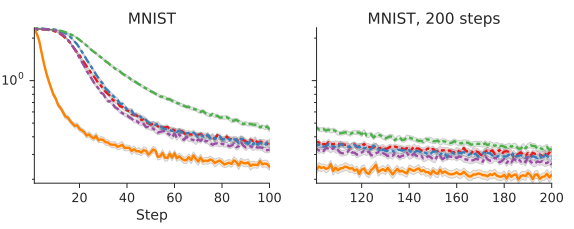

Again we get similar results!!!

In [ ]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

In [ ]:
@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(Optimizer(preproc=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [do_fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNet, 1, 200, 200, out_mul=0.1, should_train=False))

In [ ]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST')
plt.show()

In [ ]:
class MNISTNet2Layer(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(n_layers=2, *args, **kwargs)
        
class MNISTNetBig(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(layer_size=40, *args, **kwargs)
        
class MNISTRelu(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.activation = nn.ReLU()

In [ ]:
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNet2Layer, opt, **kwargs, n_tests=10))

for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNetBig, opt, **kwargs, n_tests=10))

for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTRelu, opt, **kwargs, n_tests=10))


Same as above, for a 2 layer network. Again LSTM does great even though it was trained on a single layer network, and again we are similar to the paper:

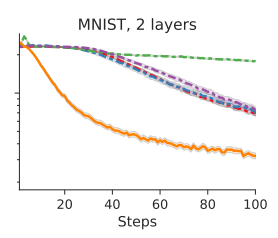

In [ ]:
QUAD_LRS = [0.01, 0.003, 0.03, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet2Layer, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNet2Layer, 1, 200, 200, out_mul=0.1, should_train=False))

In [ ]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (2 layers)')
plt.show()

Same as above but for a single layer, 40 hidden unit network.

Paper comparison:
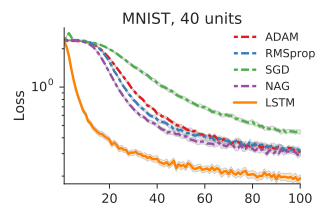

In [ ]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNetBig, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNetBig, 1, 200, 200, out_mul=0.1, should_train=False))

In [ ]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (40 hidden units)')
plt.show()

Finally, same as above but with ReLU. As we shall see, the optimizer doesn't generalize very well to a different activation function, and so the other optimizers do much better. My reproduction shows this too although strangely my optimizer seems to do better than the one from the paper.

Original:
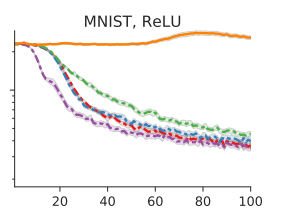

In [ ]:
QUAD_LRS = [0.03, 0.003, 0.3, 0.3]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTRelu, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTRelu, 1, 200, 200, out_mul=0.1, should_train=False))

In [ ]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (ReLU)')
plt.show()